In [1]:
from youtubesearchpython import Video
from copy import deepcopy

In [2]:
# read vid_ids.txt lines to get intial set of urls
with open('vid_ids.txt', 'r') as f:
    lines = f.readlines()
unexplored_videos = ['https://www.youtube.com/watch?v=' + line[:-1] for line in lines]
all_videos = set(deepcopy(unexplored_videos))
channels = set()

video_file = open('videos.jsonl', 'w')

# Pilot study, DFS through youtube recommendations

In [ ]:
link = unexplored_videos.pop()
new_channels_explored = []
total_videos_found = len(all_videos)
playlists = []

while len(unexplored_videos) > 0:
    # use a try block to catch request or parsing errors and skip to next video
    try:
        next_info = Video.getNextInfo(link)
        recommendations = next_info['recommendations']
        assert len(recommendations) > 0, f'no recommendations for {link}'

        new_channels = 0
        for recommendation in recommendations:
            # add to unexplored_videos if not already in channels (to stop repeat videos)
            if recommendation['channel']['link'] not in channels:
                channels.add(recommendation['channel']['link'])
                unexplored_videos.append(recommendation['link'])
                new_channels += 1

            if recommendation['isPlaylist'] is True:
                playlists.append(recommendation)
                continue

            total_videos_found += 1
            all_videos.add(recommendation['link'])
            video_file.write(str(recommendation) + '\n')
    except Exception as e:
        print(e, link)
        link = unexplored_videos.pop()
        continue

    new_channels_explored.append(new_channels)
    link = unexplored_videos.pop()
    print(
        "channels found:", len(channels),
        "unexplored videos left:", len(unexplored_videos),
        "total unique videos found:", len(all_videos),
        "total videos found:", total_videos_found,
        end = '\t\t\t\r'
    )

### see how number of new channels found changes over time

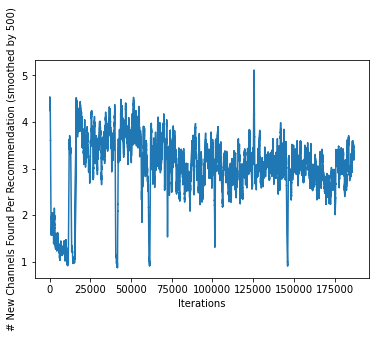

In [18]:
import numpy as np
from matplotlib import pyplot as plt

def moving_average(a, n=3):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

plt.plot(moving_average(new_channels_explored, 500))
plt.xlabel('Iterations')
plt.ylabel('# New Channels Found Per Recommendation (smoothed by 500)')
plt.show()

In [11]:
# close videos.jsonl
video_file.close()

In [5]:
import asyncio
import socket
import copy
import json
import os

from aiohttp import ClientSession, TCPConnector, DummyCookieJar

from youtube_helpers import BASE, ENDPOINT, PAYLOAD, USER_AGENT, parse_response

processing_lock = asyncio.Lock()

video_file = open('_v.txt', 'a')
channel_file = open('_c.txt', 'a')
playlist_file = open('_p.jsonl', 'a')
channels = set()

async def get_recommendations(
        video_id, session, unexplored_videos,
        channel_set = channels, lock = processing_lock,
        video_file = video_file, channel_file = channel_file,
        playlist_file = playlist_file
    ):
    data = copy.deepcopy(PAYLOAD)
    data['videoId'] = video_id
    async with session.post(ENDPOINT, headers = {'User-Agent': USER_AGENT},
                            json = data, timeout = 5) as response:
        if response.ok is False:
            return response.ok
        
        recommendations = parse_response(await response.json())
        print(recommendations)
        for recommendation in recommendations:
            async with lock:
                video_file.write(recommendation['id'] + '\n')

                if recommendation['isPlaylist']:
                    playlist_file.write(json.dumps(recommendation) + '\n')
                
                if (recommendation['channel']['link'] is not None and
                    recommendation['channel']['link'] not in channel_set):

                    channel_set.add(recommendation['channel']['link'])
                    channel_file.write(recommendation['channel']['link'] + '\n')

                    if ('shorts' not in recommendation['link'] and
                        recommendation['isPlaylist'] is not True):
                        unexplored_videos.append(recommendation['id'])

In [10]:
async with ClientSession(base_url = BASE) as session:
    video_id = "nWe3tW-XtaY"
    await get_recommendations(video_id, session, [])

[{'isPlaylist': False, 'id': 'fFLQc1ueRkQ', 'thumbnails': [{'url': 'https://i.ytimg.com/vi/fFLQc1ueRkQ/hqdefault.jpg?sqp=-oaymwE1CKgBEF5IVfKriqkDKAgBFQAAiEIYAXABwAEG8AEB-AH-CYAC0AWKAgwIABABGGUgVShBMA8=&rs=AOn4CLD57vNSjbAMU6gTJ1WJNS4gOsIN3A', 'width': 168, 'height': 94}, {'url': 'https://i.ytimg.com/vi/fFLQc1ueRkQ/hqdefault.jpg?sqp=-oaymwE1CMQBEG5IVfKriqkDKAgBFQAAiEIYAXABwAEG8AEB-AH-CYAC0AWKAgwIABABGGUgVShBMA8=&rs=AOn4CLCb9XSJLJ3o4CixKQFi4gBkJ0JQ7A', 'width': 196, 'height': 110}, {'url': 'https://i.ytimg.com/vi/fFLQc1ueRkQ/hqdefault.jpg?sqp=-oaymwE2CPYBEIoBSFXyq4qpAygIARUAAIhCGAFwAcABBvABAfgB_gmAAtAFigIMCAAQARhlIFUoQTAP&rs=AOn4CLAw-lsoY0eCC938iNgq_Y1_LE9p4w', 'width': 246, 'height': 138}, {'url': 'https://i.ytimg.com/vi/fFLQc1ueRkQ/hqdefault.jpg?sqp=-oaymwE2CNACELwBSFXyq4qpAygIARUAAIhCGAFwAcABBvABAfgB_gmAAtAFigIMCAAQARhlIFUoQTAP&rs=AOn4CLAdAOx8MirUlren3AbuYlFiiwNr1A', 'width': 336, 'height': 188}], 'title': 'Murat Aslan | Giresun Karşılaması | Canlı Performans', 'channel': {'name': 'Mur